# Desafio 3 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from efficient_apriori import apriori
from IPython.display import display
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (FunctionTransformer, KBinsDiscretizer,
                                   OneHotEncoder)

## Configurações

In [2]:
seed = 42
data_path = Path("../desafio/assets/data/")
source_url = "https://github.com/maratonadev/desafio-3-2021/raw/main/assets/data/"
set_config(display="diagram")

## Dados

### Download

In [3]:
!mkdir -p {data_path}
!wget -q -N -P {data_path} {source_url}"InvestmentBankCDE.csv"
!wget -q -N -P {data_path} {source_url}"RetailBankEFG.csv"
!wget -q -N -P {data_path} {source_url}"InsuranceCompanyABC.csv"
!wget -q -N -P {data_path} {source_url}"ANSWERS.csv"
!ls {data_path}

ANSWERS.csv  InsuranceCompanyABC.csv  InvestmentBankCDE.csv  RetailBankEFG.csv


### Carregamento

In [4]:
retail = pd.read_csv(data_path / "RetailBankEFG.csv", index_col="ID")
retail_cols = list(retail.columns)
print(retail_cols)

['Financiamento Casa', 'Financiamento Carro', 'Emprestimo _pessoal', 'Emprestimo _consignado', 'Emprestimo _limite_especial', 'Emprestimo _educacao', 'Emprestimo _viagem', 'Investimento CDB', 'Investimento Fundos']


In [5]:
investment = pd.read_csv(data_path / "InvestmentBankCDE.csv", index_col="ID")
investment_cols = list(investment.columns)
print(investment_cols)

['Investimento Fundos_cambiais', 'Investimento Fundos_commodities', 'Investimento LCI', 'Investimento LCA', 'Investimento Poupanca', 'Investimento Fundos Multimercado', 'Investimento Tesouro Direto']


In [6]:
insurance = pd.read_csv(data_path / "InsuranceCompanyABC.csv", index_col="ID")
insurance_cols = list(insurance.columns)
print(insurance_cols)

['Idade', 'Renda', 'Regiao', 'Genero', 'seguro auto', 'seguro vida Emp', 'seguro vida PF', 'Seguro Residencial']


In [7]:
answers = pd.read_csv(data_path / "ANSWERS.csv")
print(list(answers.columns))

['ID', 'Idade', 'Renda', 'Regiao', 'Genero', 'seguro auto', 'seguro vida Emp', 'seguro vida PF', 'Seguro Residencial', 'Investimento Fundos_cambiais', 'Investimento Fundos_commodities', 'Investimento LCI', 'Investimento LCA', 'Investimento Poupanca', 'Investimento Fundos Multimercado', 'Investimento Tesouro Direto', 'Financiamento Casa', 'Financiamento Carro', 'Emprestimo _pessoal', 'Emprestimo _consignado', 'Emprestimo _limite_especial', 'Emprestimo _educacao', 'Emprestimo _viagem', 'Investimento CDB', 'Investimento Fundos', 'RECOMMENDATION_1', 'CONFIDENCE_1', 'RECOMMENDATION_2', 'CONFIDENCE_2', 'RECOMMENDATION_3', 'CONFIDENCE_3']


In [8]:
assert insurance.index.equals(investment.index) and insurance.index.equals(retail.index)

df_all = pd.concat([insurance, investment, retail], axis=1).reset_index()

### Dados repetidos

Há várias linhas duplicadas no conjunto de dados:

In [9]:
df_all.duplicated().sum()

77

Podemos remover essas linhas:

In [10]:
df_unique = df_all.drop_duplicates().reset_index(drop=True)
df_unique.duplicated().sum()

0

Apesar de agora não haver linhas totalmente iguais, os índices (`ID`) de alguns clientes ainda ocorrem mais de uma vez

In [11]:
display(df_unique["ID"].astype("category").describe().to_frame())

,ID
count,10005.0
unique,9530.0
top,73519.0
freq,3.0


### Dados de exemplo

A título de exemplo, estes são dois dos clientes que têm mais de um registro (ordenados por idade, e mostrando apenas algumas colunas em que houve mudanças entre os registros):

In [12]:
def get_sample(df):
    common_ids = df["ID"].value_counts().head(2).index
    return df[df["ID"].isin(common_ids)].sort_values(["ID", "Idade"])


with pd.option_context("display.max_columns", None):
    display(get_sample(df_unique))

,ID,Idade,Renda,Regiao,Genero,seguro auto,seguro vida Emp,seguro vida PF,Seguro Residencial,Investimento Fundos_cambiais,Investimento Fundos_commodities,Investimento LCI,Investimento LCA,Investimento Poupanca,Investimento Fundos Multimercado,Investimento Tesouro Direto,Financiamento Casa,Financiamento Carro,Emprestimo _pessoal,Emprestimo _consignado,Emprestimo _limite_especial,Emprestimo _educacao,Emprestimo _viagem,Investimento CDB,Investimento Fundos
6904,51384.0,25.939,7911.566,NE,1.0,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,T,F
5114,51384.0,40.324,7539.159,CO,1.0,F,F,F,F,T,T,T,F,T,F,T,F,T,F,F,F,F,F,F,F
300,51384.0,57.285,5975.963,NE,0.0,F,F,F,F,T,T,F,F,F,T,F,F,F,T,F,T,F,F,F,T
6315,93761.0,43.713,7785.539,CO,0.0,T,T,T,T,T,T,T,T,T,F,T,F,F,F,F,F,F,T,T,T
3978,93761.0,54.415,7301.510,CO,0.0,F,T,F,F,F,T,F,F,F,F,F,F,F,F,F,F,F,F,F,F
5596,93761.0,55.779,7639.373,SE,1.0,F,F,F,F,F,F,F,F,F,F,F,F,T,F,F,F,F,F,T,T


Conforme o tempo vai passando, a renda desses clientes varia, eles mudam para outra região do país, e sua carteira de investimentos vai se alterando.

### Informações gerais

In [13]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005 entries, 0 to 10004
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                10005 non-null  float64
 1   Idade                             10005 non-null  float64
 2   Renda                             10005 non-null  float64
 3   Regiao                            10005 non-null  object 
 4   Genero                            10005 non-null  float64
 5   seguro auto                       10005 non-null  object 
 6   seguro vida Emp                   10005 non-null  object 
 7   seguro vida PF                    10005 non-null  object 
 8   Seguro Residencial                10005 non-null  object 
 9   Investimento Fundos_cambiais      10005 non-null  object 
 10  Investimento Fundos_commodities   10005 non-null  object 
 11  Investimento LCI                  10005 non-null  object 
 12  Inve

Neste conjunto de dados:
- Há tanto variáveis numéricas quanto categóricas/booleanas
- Não há dados faltantes

### Pré-processamento

A variável `ID` será desconsiderada.

As variáveis contínuas serão discretizadas de modo a agrupar os clientes:
- Em dois grupos de `Idade`: `young` e `old`
- Em dois grupos de `Renda`: `low_income` e `high_income`

Cada um desses grupos dará origem a uma variável binária que indica se o cliente está ou não naquele grupo.

De forma análoga, a variável `Regiao` será transformada em variáveis binárias, uma para cada valor.

Já as variáveis binárias com valores `T` e `F` serão convertidas para valores numéricos, de modo que `1` sempre corresponda ao caso verdadeiro e `0` ao falso.

In [14]:
int_cols = ["ID"]
float_cols = ["Idade", "Renda"]
cat_cols = ["Regiao"]
bool_cols = [
    "Genero",
    "seguro auto",
    "seguro vida Emp",
    "seguro vida PF",
    "Seguro Residencial",
    "Investimento Fundos_cambiais",
    "Investimento Fundos_commodities",
    "Investimento LCI",
    "Investimento LCA",
    "Investimento Poupanca",
    "Investimento Fundos Multimercado",
    "Investimento Tesouro Direto",
    "Financiamento Casa",
    "Financiamento Carro",
    "Emprestimo _pessoal",
    "Emprestimo _consignado",
    "Emprestimo _limite_especial",
    "Emprestimo _educacao",
    "Emprestimo _viagem",
    "Investimento CDB",
    "Investimento Fundos",
]


def bool_mapper(df):
    bool_map = {"T": True, 1: True, 0: False, "F": False}

    def col_mapper(col):
        return col.map(bool_map)

    return df.apply(col_mapper)


preprocessor = ColumnTransformer(
    transformers=[
        # ("id_col", FunctionTransformer(), ["ID"]),
        ("age_col", KBinsDiscretizer(n_bins=2, encode="onehot-dense"), ["Idade"]),
        ("income_col", KBinsDiscretizer(n_bins=2, encode="onehot-dense"), ["Renda"]),
        ("region_col", OneHotEncoder(handle_unknown="ignore"), ["Regiao"]),
        ("bool_cols", FunctionTransformer(bool_mapper), bool_cols),
    ],
    remainder="drop",
)
display(preprocessor)

preprocessor.fit(df_unique)

age_features = ["young", "old"]
income_features = [
    "low_income",
    "high_income",
]
region_features = [
    col[3:]
    for col in preprocessor.named_transformers_["region_col"].get_feature_names()
]
item_cols = age_features + income_features + region_features + bool_cols


def preprocess(df):
    return pd.DataFrame(
        preprocessor.transform(df),
        columns=item_cols,
        index=df.index,
    )


df = preprocess(df_unique)

with pd.option_context("display.max_columns", 24):
    display(df_unique.head(3))
    display(df.head(3))

ColumnTransformer(transformers=[('age_col',
                                 KBinsDiscretizer(encode='onehot-dense',
                                                  n_bins=2),
                                 ['Idade']),
                                ('income_col',
                                 KBinsDiscretizer(encode='onehot-dense',
                                                  n_bins=2),
                                 ['Renda']),
                                ('region_col',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Regiao']),
                                ('bool_cols',
                                 FunctionTransformer(func=<function bool_mapper at 0x7facb42b21f0>),
                                 ['Genero', 'seguro auto', 'seguro v...
                                  'Investimento Fundos_commodities',
                                  'Investimento LCI', 'Investimento LCA',
                                  'Investimento Poupanca',
                                  'Investimento Fundos Multimercado',
                                  'Investimento Tesouro Direto',
                                  'Financiamento Casa', 'Financiamento Carro',
                                  'Emprestimo _pessoal',
                                  'Emprestimo _consignado',
                                  'Emprestimo _limite_especial',
                                  'Emprestimo _educacao', 'Emprestimo _viagem',
                                  'Investimento CDB', 'Investimento Fundos'])])

,ID,Idade,Renda,Regiao,Genero,seguro auto,seguro vida Emp,seguro vida PF,Seguro Residencial,Investimento Fundos_cambiais,Investimento Fundos_commodities,Investimento LCI,...,Investimento Poupanca,Investimento Fundos Multimercado,Investimento Tesouro Direto,Financiamento Casa,Financiamento Carro,Emprestimo _pessoal,Emprestimo _consignado,Emprestimo _limite_especial,Emprestimo _educacao,Emprestimo _viagem,Investimento CDB,Investimento Fundos
0,71504.0,42.993,4428.512,NE,1.0,T,T,T,T,F,F,F,...,F,F,F,T,T,T,T,T,F,F,T,F
1,59751.0,26.373,4489.930,CO,0.0,T,T,T,T,F,F,F,...,F,F,F,T,T,T,T,T,F,F,F,T
2,11877.0,46.977,4567.741,CO,0.0,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F,F,F


,young,old,low_income,high_income,CO,N,NE,S,SE,Genero,seguro auto,seguro vida Emp,...,Investimento Poupanca,Investimento Fundos Multimercado,Investimento Tesouro Direto,Financiamento Casa,Financiamento Carro,Emprestimo _pessoal,Emprestimo _consignado,Emprestimo _limite_especial,Emprestimo _educacao,Emprestimo _viagem,Investimento CDB,Investimento Fundos
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Descrição dos dados

In [15]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
young,10005.0,0.499950,0.500025,0.0,0.0,0.0,1.0,1.0
old,10005.0,0.500050,0.500025,0.0,0.0,1.0,1.0,1.0
low_income,10005.0,0.499950,0.500025,0.0,0.0,0.0,1.0,1.0
high_income,10005.0,0.500050,0.500025,0.0,0.0,1.0,1.0,1.0
CO,10005.0,0.171314,0.376802,0.0,0.0,0.0,0.0,1.0
N,10005.0,0.049675,0.217284,0.0,0.0,0.0,0.0,1.0
NE,10005.0,0.178011,0.382541,0.0,0.0,0.0,0.0,1.0
S,10005.0,0.149025,0.356131,0.0,0.0,0.0,0.0,1.0
SE,10005.0,0.451974,0.497713,0.0,0.0,0.0,1.0,1.0
Genero,10005.0,0.549225,0.497596,0.0,0.0,1.0,1.0,1.0


Observações:
- Mais da metade das transações (55%) são de clientes de um dos gêneros
- O `Investimento CDB` está presence em cerca de metade das transações
- Cerca de 45% das transações foram na região `SE`

## Recomendação de produtos

### Produtos disponíveis

In [16]:
products = [
    "seguro auto",
    "seguro vida Emp",
    "seguro vida PF",
    "Seguro Residencial",
    "Investimento Fundos_cambiais",
    "Investimento Fundos_commodities",
    "Investimento LCI",
    "Investimento LCA",
    "Investimento Poupanca",
    "Investimento Fundos Multimercado",
    "Investimento Tesouro Direto",
    "Financiamento Casa",
    "Financiamento Carro",
    "Emprestimo _pessoal",
    "Emprestimo _consignado",
    "Emprestimo _limite_especial",
    "Emprestimo _educacao",
    "Emprestimo _viagem",
    "Investimento CDB",
    "Investimento Fundos",
]

### Transações

In [17]:
def get_transactions(df):
    def get_transaction_products(row):
        return tuple(row[item_cols].index[row[item_cols].astype(bool)])

    return df.apply(get_transaction_products, axis=1).tolist()

In [18]:
transactions = get_transactions(df)

display(transactions[5:8])

[('old',
  'low_income',
  'CO',
  'Investimento Fundos Multimercado',
  'Financiamento Carro',
  'Emprestimo _pessoal',
  'Emprestimo _educacao'),
 ('old', 'low_income', 'SE', 'Investimento Fundos Multimercado'),
 ('old', 'low_income', 'SE', 'Genero')]

### Geração de regras de associação com Apriori

In [19]:
def get_relevant_rules(transactions):
    itemsets, rules = apriori(
        transactions, min_support=0.1, min_confidence=0.8, max_length=5
    )
    result = list(filter(lambda rule: set(rule.rhs).issubset(set(products)), rules))
    return result

In [20]:
rules = get_relevant_rules(transactions)

data = [
    {
        "antecedent": r.lhs,
        "consequent": r.rhs,
        "conf": r.confidence,
        "supp": r.support,
        "lift": r.lift,
        "conv": r.conviction,
        "rule": r,
    }
    for r in rules
]
df_rules = pd.DataFrame(data).sort_values("lift")
with pd.option_context("display.max_colwidth", None, "display.max_rows", 4):
    display(df_rules.drop("rule", axis=1))

,antecedent,consequent,conf,supp,lift,conv
19,"(Investimento Fundos, Investimento Fundos_commodities)","(Investimento CDB,)",0.819031,0.140230,1.628459,2.746610
20,"(Investimento Fundos, Investimento LCI)","(Investimento CDB,)",0.823850,0.136032,1.638040,2.821749
...,...,...,...,...,...,...
6,"(Emprestimo _consignado, Emprestimo _pessoal)","(Emprestimo _limite_especial,)",0.964077,0.115342,6.028493,23.385481
5,"(Emprestimo _limite_especial, Emprestimo _pessoal)","(Emprestimo _consignado,)",0.956882,0.115342,6.086209,19.545980


Em alguns casos, mais de uma regra pode ter o mesmo antecedente:

In [21]:
df_rules["antecedent"].value_counts().rename("Nº de regras").to_frame().head()

,Nº de regras
"(Investimento CDB, seguro vida PF)",7
"(seguro vida PF, young)",7
"(seguro vida PF,)",5
"(Investimento Fundos_cambiais, Investimento LCA)",4
"(Investimento Fundos_commodities, Investimento LCA)",4


In [22]:
# For each antecedent set, keep a single rule with the greatest lift
# Then order the rules so that the ones with greatest lift are applied last
# and therefore override the ones with lower lift
df_best_rules = (
    df_rules.sort_values("lift", ascending=False)
    .drop_duplicates(["antecedent"])
    .sort_values("lift", ascending=True)
)
best_rules = df_best_rules["rule"].tolist()

### Visualização das métricas de avaliação das regras

In [23]:
df_best_rules_long = (
    df_best_rules.drop("rule", axis=1)
    .set_index(["antecedent", "consequent"])
    .stack()
    .to_frame()
    .reset_index()
    .rename(columns={0: "value", "level_2": "metric"})
)

with pd.option_context("display.max_colwidth", None, "display.max_rows", 4):
    display(df_best_rules_long)

,antecedent,consequent,metric,value
0,"(Investimento Fundos, Investimento Fundos_commodities)","(Investimento CDB,)",conf,0.819031
1,"(Investimento Fundos, Investimento Fundos_commodities)","(Investimento CDB,)",supp,0.140230
...,...,...,...,...
446,"(Emprestimo _limite_especial, Emprestimo _pessoal)","(Emprestimo _consignado,)",lift,6.086209
447,"(Emprestimo _limite_especial, Emprestimo _pessoal)","(Emprestimo _consignado,)",conv,19.545980


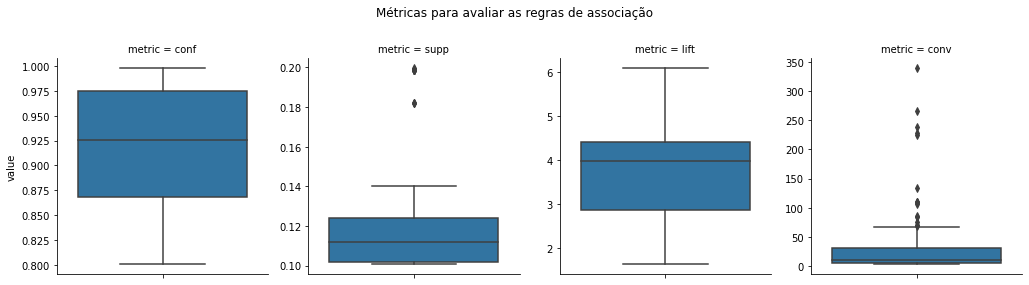

In [24]:
g = sns.catplot(
    y="value",
    col="metric",
    data=df_best_rules_long,
    kind="box",
    height=4,
    aspect=0.9,
    sharey=False,
)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Métricas para avaliar as regras de associação")
plt.show()

### Aplicação das regras

In [25]:
target_cols = [
    "RECOMMENDATION_1",
    "CONFIDENCE_1",
    "RECOMMENDATION_2",
    "CONFIDENCE_2",
    "RECOMMENDATION_3",
    "CONFIDENCE_3",
]

In [26]:
def apply_single_rule(df, rule):
    df = df.copy()

    is_in_antecedent = list(rule.lhs)
    # is_not_in_antecedent = list(set(item_cols) - set(rule.lhs))
    relevant_rows = df[is_in_antecedent].all(
        axis=1
    )  # & (~df[is_not_in_antecedent].any(axis=1))
    df.loc[relevant_rows, target_cols] = np.nan
    for idx in range(1, 1 + min(len(rule.rhs), 3)):
        cols = [f"RECOMMENDATION_{idx}", f"CONFIDENCE_{idx}"]
        df.loc[relevant_rows, cols] = (rule.rhs[idx - 1], rule.confidence)
    return df


def apply_rules(df, rules):
    df_features = df.drop(target_cols, axis=1)

    result = preprocess(df_features)
    for rule in rules:
        result = apply_single_rule(result, rule)

    result = pd.concat([df_features, result[target_cols]], axis=1)
    return result

In [27]:
filled_answers = apply_rules(answers, best_rules)

print("Proporção de linhas para as quais cada recomendação foi preenchida:")
display((~filled_answers.isna()).mean().tail(6).rename("Proporção").to_frame())

Proporção de linhas para as quais cada recomendação foi preenchida:


,Proporção
RECOMMENDATION_1,0.649599
CONFIDENCE_1,0.649599
RECOMMENDATION_2,0.419374
CONFIDENCE_2,0.419374
RECOMMENDATION_3,0.009541
CONFIDENCE_3,0.009541


## Preenchimento do arquivo de respostas

In [28]:
filled_answers.to_csv("ANSWERS.csv", index=False)

In [29]:
!rm -rf código.zip
!zip -q código.zip notebook.ipynb
!ls código.zip

código.zip
